# [[4, 1, 2]] Code

In [1]:
from qiskit import __version__
print(__version__)

2.1.1


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, Pauli
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.circuit.controlflow import IfElseOp
from qiskit.circuit.library import XGate, ZGate
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

In [4]:
# Custom Hadamard 
h_sub = QuantumCircuit(1, name='H_custom')
h_sub.h(0)
H_custom = h_sub.to_gate()

# Custom CY
cy_sub = QuantumCircuit(2, name='CY_custom')
cy_sub.cy(0, 1)
CY_custom = cy_sub.to_gate()

# Custom S Gate
s_sub = QuantumCircuit(1, name='S_custom')
s_sub.s(0)
S_custom = s_sub.to_gate()

# Custom Sdg Gate
sdg_sub = QuantumCircuit(1, name='Sdg_custom')
sdg_sub.sdg(0)
Sdg_custom = sdg_sub.to_gate()

# Custom CZ Gate
cz_sub = QuantumCircuit(2, name='CZ_custom')
cz_sub.cz(0, 1)
CZ_custom = cz_sub.to_gate()

# Custom X Gate
x_sub = QuantumCircuit(1, name='X_custom')
x_sub.x(0)
X_custom = x_sub.to_gate()

# Custom Z Gate
z_sub = QuantumCircuit(1, name='Z_custom')
z_sub.z(0)
Z_custom = z_sub.to_gate()

# Function for Encoding

In [5]:
def encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit+3)
    for i in range(4):
        qc.id(first_qubit+i)
    
    qc.sdg(first_qubit+3)
    qc.h(first_qubit+3)
    qc.s(first_qubit)
    qc.h(first_qubit+2)
    qc.cy(first_qubit+2, first_qubit+3)
    qc.cz(first_qubit, first_qubit+2)
    qc.h(first_qubit+1)
    qc.cz(first_qubit+1, first_qubit+3)
    qc.cy(first_qubit+1, first_qubit+2)
    qc.h(first_qubit)
    qc.cz(first_qubit, first_qubit+2)
    qc.cy(first_qubit, first_qubit+1)

In [6]:
def perfect_encoding(qc: QuantumCircuit, first_qubit: int):
    qc.initialize([amp_0, amp_1], first_qubit+3)
    
    qc.append(Sdg_custom, [first_qubit+3])
    qc.append(H_custom, [first_qubit+3])
    qc.append(S_custom, [first_qubit])
    qc.append(H_custom, [first_qubit+2])
    qc.append(CY_custom, [first_qubit+2, first_qubit+3])
    qc.append(CZ_custom, [first_qubit, first_qubit+2])
    qc.append(H_custom, [first_qubit+1])
    qc.append(CZ_custom, [first_qubit+1, first_qubit+3])
    qc.append(CY_custom, [first_qubit+1, first_qubit+2])
    qc.append(H_custom, [first_qubit])
    qc.append(CZ_custom, [first_qubit, first_qubit+2])
    qc.append(CY_custom , [first_qubit, first_qubit+1])

# Functions for Syndrome Measurements

In [7]:
def s1(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister):
    # XYZI
    qc.h(first_qubit)
    qc.cx(first_qubit, first_qubit+4)
    qc.h(first_qubit)
    
    qc.sdg(first_qubit+1)
    qc.h(first_qubit+1)
    qc.cx(first_qubit+1, first_qubit+4)
    qc.h(first_qubit+1)
    qc.s(first_qubit+1)
    
    qc.cx(first_qubit+2, first_qubit+4)
    
    qc.measure([first_qubit+4], c1)

In [8]:
def s2(qc: QuantumCircuit, first_qubit: int, c2: ClassicalRegister):
    # IXYZ
    qc.h(first_qubit+1)
    qc.cx(first_qubit+1, first_qubit+4)
    qc.h(first_qubit+1)
    
    qc.sdg(first_qubit+2)
    qc.h(first_qubit+2)
    qc.cx(first_qubit+2, first_qubit+4)
    qc.h(first_qubit+2)
    qc.s(first_qubit+2)
    
    qc.cx(first_qubit+3, first_qubit+4)
    
    qc.measure([first_qubit+4], c2)

In [9]:
def s3(qc: QuantumCircuit, first_qubit: int, c3: ClassicalRegister):
    # ZIXY
    qc.cx(first_qubit, first_qubit+4)
    
    qc.h(first_qubit+2)
    qc.cx(first_qubit+2, first_qubit+4)
    qc.h(first_qubit+2)
    
    qc.sdg(first_qubit+3)
    qc.h(first_qubit+3)
    qc.cx(first_qubit+3, first_qubit+4)
    qc.h(first_qubit+3)
    qc.s(first_qubit+3)
    
    qc.measure([first_qubit+4], c3)

# Function for QEC

In [10]:
def QEC(qc: QuantumCircuit, first_qubit: int, c1: ClassicalRegister, c2: ClassicalRegister, c3: ClassicalRegister):
    s1(qc, first_qubit, c1)
    qc.reset([4])
    s2(qc, first_qubit, c2)
    qc.reset([4])
    s3(qc, first_qubit, c3)

# Encoding + 1 Round of EC

In [43]:
ideal = QuantumCircuit(4)
perfect_encoding(ideal, 0)
ideal = DensityMatrix(ideal)

err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()
    
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['s'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['sdg'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cy'])

    # p2 chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [4]) 
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(5)

    c1 = ClassicalRegister(1)
    c2 = ClassicalRegister(1)
    c3 = ClassicalRegister(1)

    qc.add_register(c1, c2, c3)

    encoding(qc, 0)
    QEC(qc, 0, c1, c2, c3)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=100000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv5 = next(iter(result.items()))
        if (memory[i] == '0 0 0'):
            sv_correction.append(sv5)
        else:
            continue
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [4])
        if (sv == ideal):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(sum / len(sv_correction))

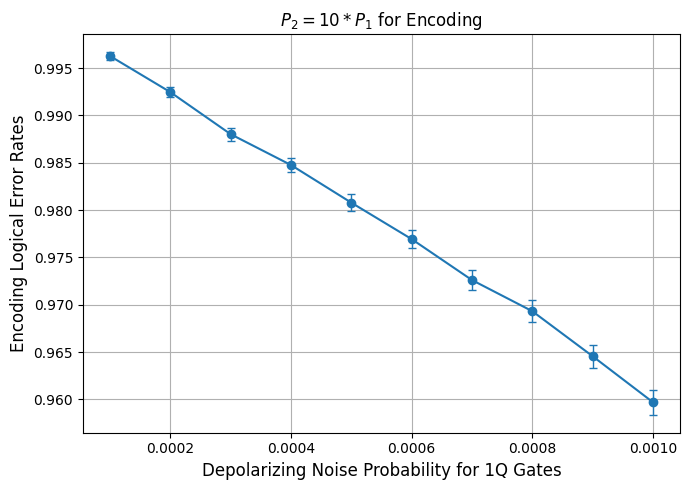

In [44]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$ for Encoding")
plt.grid(True)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.show()

# Logical Error Rate for Hadamard

In [45]:
ideal = QuantumCircuit(4)
perfect_encoding(ideal, 0)
ideal.append(X_custom, [0])
ideal.append(X_custom, [2])
for i in range(4):
    ideal.append(H_custom, [i])
ideal.append(Z_custom, [3])
ideal.append(X_custom, [2])
ideal = DensityMatrix(ideal)

err_rates = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
logical_error_rates = []
unc = []

for p1 in err_rates:
    #################################################################################
    # Error model
    p2 = p1 * 10
    noise_model = NoiseModel()
    
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['id'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['s'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1,1), ['sdg'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cx'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2,2), ['cy'])

    # p2 chance of flipping 0 <-> 1
    readout_err = ReadoutError([[1-p2, p2],  # P(measured 0 | actual 0), P(1 | 0)
                                [p2, 1-p2]]) # P(0 | 1), P(1 | 1)

    # Apply to all qubits being measured
    noise_model.add_readout_error(readout_err, [4]) 
    #################################################################################
    # Encoding + 1 Round of EC and running shots
    qc = QuantumCircuit(5)

    c1 = ClassicalRegister(1)
    c2 = ClassicalRegister(1)
    c3 = ClassicalRegister(1)

    qc.add_register(c1, c2, c3)

    encoding(qc, 0)
    QEC(qc, 0, c1, c2, c3)
    # Applying logical H
    qc.x(0)
    qc.x(2)
    for i in range(4):
        qc.h(i)
    qc.z(3)
    qc.x(2)

    qc.save_statevector(label='statevector_post', pershot=True, conditional=True)

    backend = AerSimulator(noise_model=noise_model)
    transpiled = transpile(qc, backend, optimization_level=0)
    job = backend.run(transpiled, shots=100000, memory=True)
    result = job.result()
    memory = result.get_memory()
    #################################################################################
    # Create array with keys (hex results) and values (statevectors)
    hex_to_sv = []
    hex_mem = result.data()['memory']

    seen = defaultdict(int)
    for mem in hex_mem:
        idx = seen[mem]
        val = result.data()['statevector_post'][mem][idx]
        hex_to_sv.append({mem:val})
        seen[mem] += 1
    #################################################################################
    # Apply corrections to each statevector in above array
    sv_correction = []
    for i, result in enumerate(hex_to_sv):
        hex, sv5 = next(iter(result.items()))
        if (memory[i] == '0 0 0'):
            sv_correction.append(sv5)
        else:
            continue
    #################################################################################
    # Count the correct outputs
    sum = 0
    for sv in sv_correction:
        sv = partial_trace(sv, [4])
        if (sv == ideal):
            sum += 1
    #################################################################################
    # Computing uncertainty and add to uncertainty array
    num_meas = len(sv_correction)
    error_rate = sum / num_meas
    unc.append(1.96 * np.sqrt( (error_rate * (1 - error_rate) / num_meas) ))
    #################################################################################
    # Add logical error rate to resulting array
    logical_error_rates.append(sum / len(sv_correction))

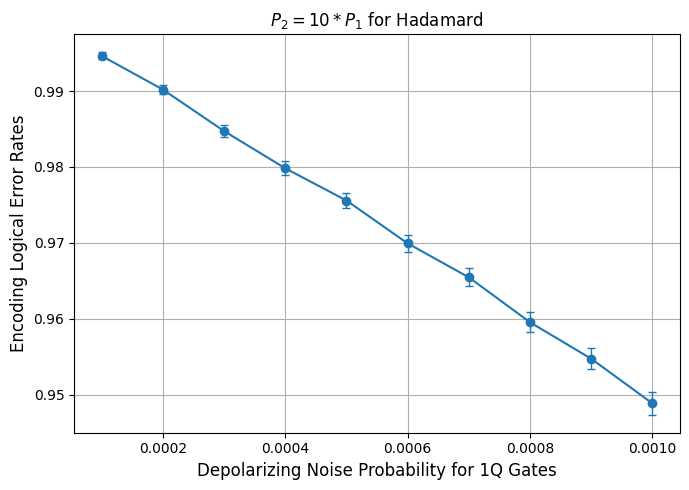

In [46]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    err_rates,
    logical_error_rates,
    yerr=unc,
    fmt='o-',           # circle marker and solid line
    capsize=3,          # length of the little “T” caps on each bar
    elinewidth=1,       # width of the error‐bar lines
    markeredgewidth=1
)
plt.xlabel("Depolarizing Noise Probability for 1Q Gates", fontsize=12)
plt.ylabel("Encoding Logical Error Rates", fontsize=12)
plt.title(f"$P_2 = 10 * P_1$ for Hadamard")
plt.grid(True)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.show()